In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!curl -L "https://app.roboflow.com/ds/vpjyhvbIdU?key=7fRYXO8ilw" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip
%cd /content/
%mkdir images/
%mv train images/train
%mv test images/test
%mv valid images/valid

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   903  100   903    0     0   1919      0 --:--:-- --:--:-- --:--:--  1917
100 54.2M  100 54.2M    0     0  31.3M      0  0:00:01  0:00:01 --:--:-- 86.5M
Archive:  roboflow.zip
  inflating: README.dataset.txt      
  inflating: README.roboflow.txt     
   creating: test/
   creating: test/Raw/
 extracting: test/Raw/00000023_jpg.rf.195cd2cd87c1fd9560e902262a7e6f51.jpg  
 extracting: test/Raw/00000137_jpg.rf.b716d48a59533a78518b5dce47cdf309.jpg  
 extracting: test/Raw/00000152_jpg.rf.bf33e9705eed708e8f9257af658bcd44.jpg  
 extracting: test/Raw/IMG_0242_JPG_jpg.rf.62bfb72aa8b003d6e309543fd92af883.jpg  
 extracting: test/Raw/IMG_0245_JPG_jpg.rf.9ade7c2de3aa49a7e3db16bb5b55d920.jpg  
 extracting: test/Raw/IMG_0247_JPG_jpg.rf.10bdb38cecd9ed153f5ed9baa722bc89.jpg  
 extracting: test/Raw/IMG_0247_JPG_jpg.rf.1387b4dc2b1e29493f3c94fa403

In [3]:
import tensorflow_datasets as tfds
builder = tfds.folder_dataset.ImageFolder('images/')
print(builder.info)
raw_train = builder.as_dataset(split='train', shuffle_files=True)
raw_test = builder.as_dataset(split='test', shuffle_files=True)
raw_valid = builder.as_dataset(split='valid', shuffle_files=True)

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_dir='/root/tensorflow_datasets/image_folder/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=189, num_shards=1>,
        'train': <SplitInfo num_examples=600, num_shards=1>,
        'valid': <SplitInfo num_examples=200, num_shards=1>,
    },
    citation="""""",
)


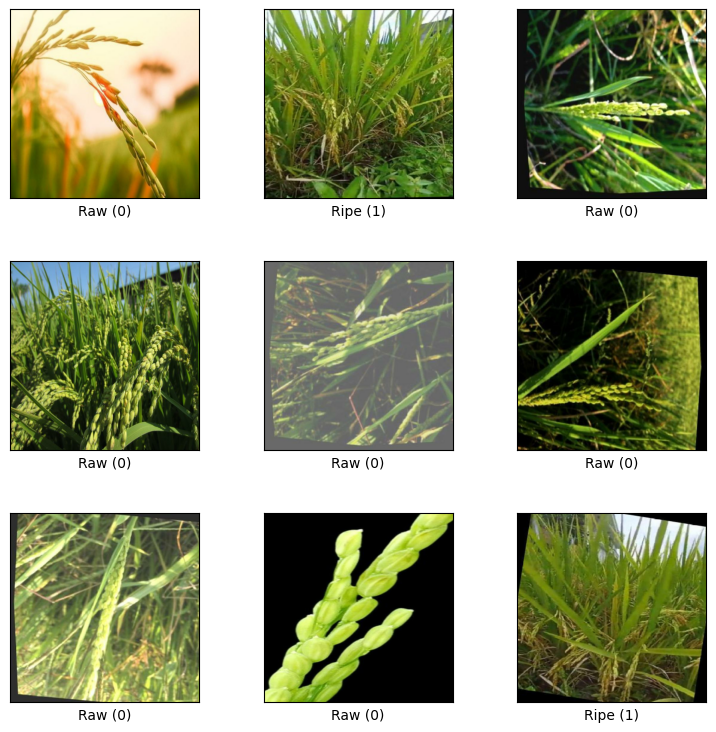

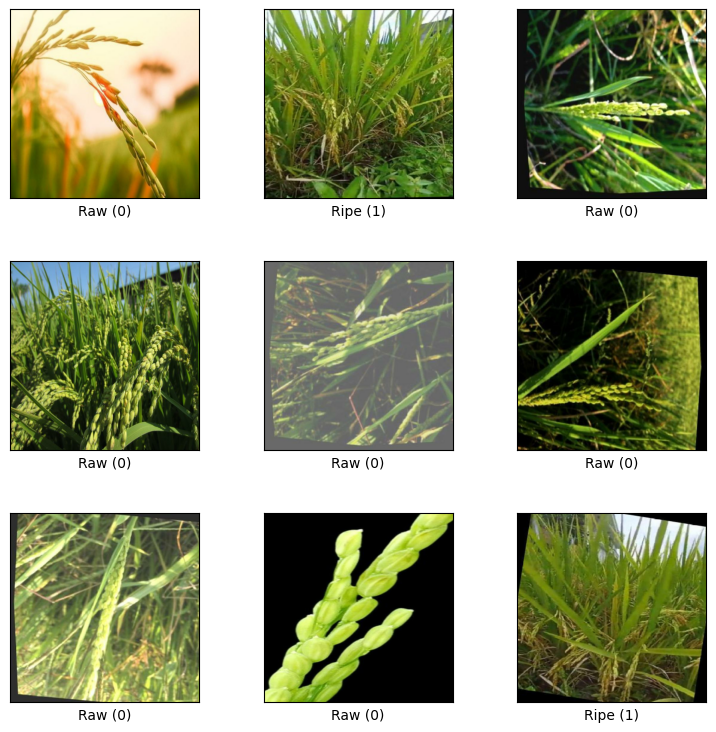

In [4]:
tfds.show_examples(raw_train, builder.info)

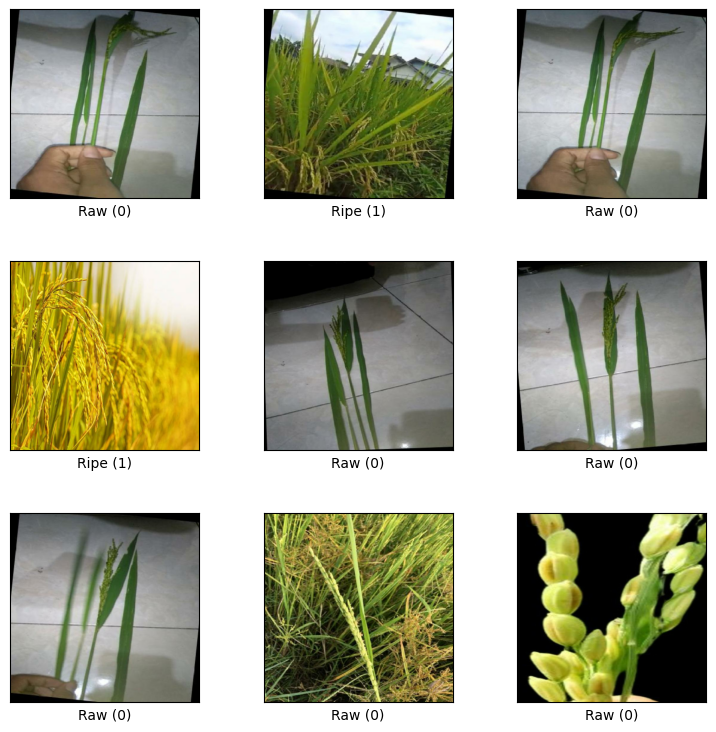

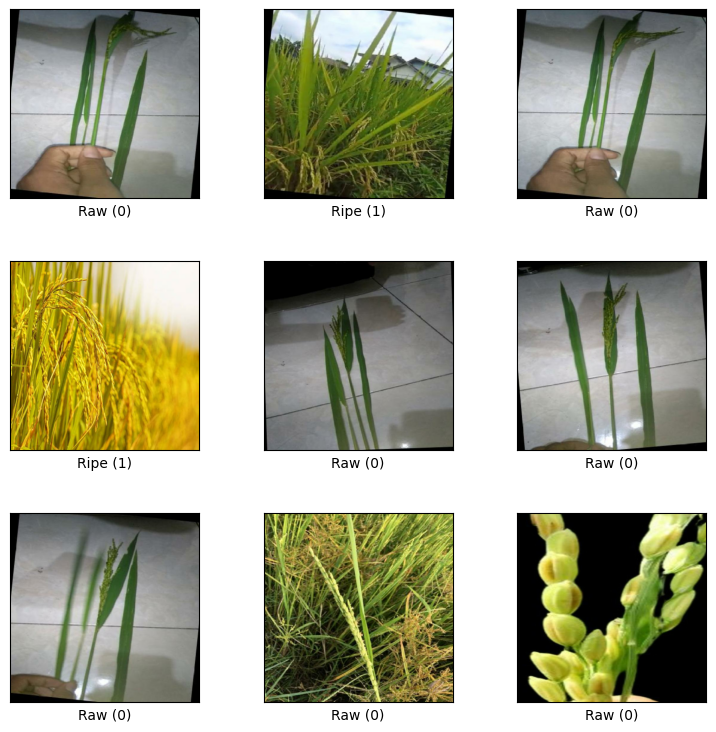

In [5]:
tfds.show_examples(raw_test, builder.info)

In [6]:
IMG_SIZE = 160

def format_example(pair):
  image, label = pair['image'], pair['label']
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [7]:
train = raw_train.map(format_example)
validation = raw_valid.map(format_example)
test = raw_test.map(format_example)

In [8]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [9]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [10]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [11]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


In [12]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [13]:
base_model.trainable = False

In [14]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [17]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [20]:
len(model.trainable_variables)

2

In [21]:
steps_per_epoch = len(validation) // BATCH_SIZE

steps_per_epoch

6

In [22]:
initial_epochs = 20
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

 7/20 [=========>....................] - ETA: 2s - loss: 0.7189 - accuracy: 0.4850

20/20 [==============================] - 6s 61ms/step - loss: 0.7189 - accuracy: 0.4850


In [23]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.72
initial accuracy: 0.49


In [24]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/20
19/19 [==============================] - 9s 154ms/step - loss: 0.6455 - accuracy: 0.5733 - val_loss: 0.6130 - val_accuracy: 0.6050
Epoch 2/20
19/19 [==============================] - 3s 64ms/step - loss: 0.5798 - accuracy: 0.6417 - val_loss: 0.5537 - val_accuracy: 0.6750
Epoch 3/20
19/19 [==============================] - 3s 55ms/step - loss: 0.5347 - accuracy: 0.7150 - val_loss: 0.5049 - val_accuracy: 0.7100
Epoch 4/20
19/19 [==============================] - 2s 54ms/step - loss: 0.4973 - accuracy: 0.7600 - val_loss: 0.4636 - val_accuracy: 0.7600
Epoch 5/20
19/19 [==============================] - 3s 104ms/step - loss: 0.4667 - accuracy: 0.7850 - val_loss: 0.4322 - val_accuracy: 0.7950
Epoch 6/20
19/19 [==============================] - 3s 56ms/step - loss: 0.4418 - accuracy: 0.8017 - val_loss: 0.4050 - val_accuracy: 0.8150
Epoch 7/20
19/19 [==============================] - 2s 57ms/step - loss: 0.4196 - accuracy: 0.8067 - val_loss: 0.3813 - val_accuracy: 0.8400
Epoch 8/20


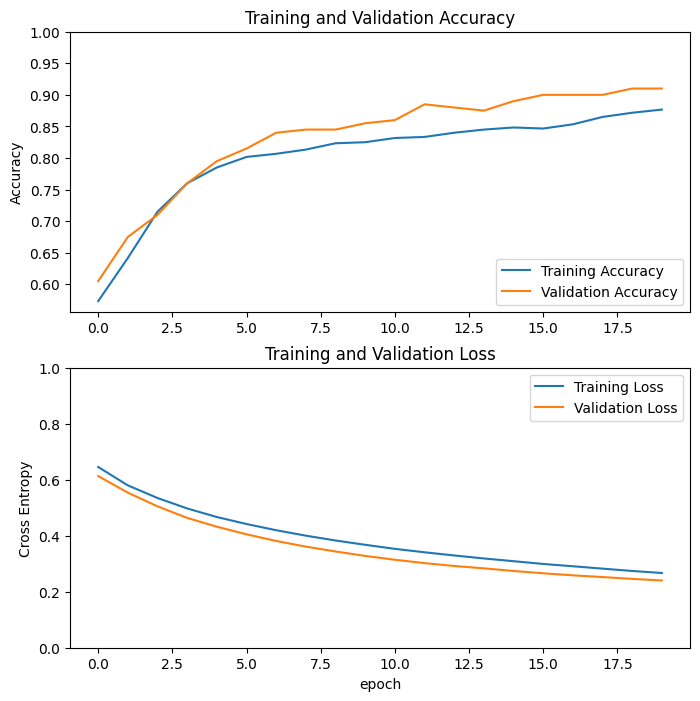

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
base_model.trainable = True

In [27]:
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [28]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1862721 (7.11 MB)
Non-trainable params: 396544 (1.51 MB)
_________________________________________________________________


In [30]:
len(model.trainable_variables)

56

In [31]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch =  history.epoch[-1],
                         validation_data=validation_batches)

Epoch 20/30
19/19 [==============================] - 13s 134ms/step - loss: 0.3985 - accuracy: 0.7567 - val_loss: 0.2124 - val_accuracy: 0.9200
Epoch 21/30
19/19 [==============================] - 3s 73ms/step - loss: 0.2815 - accuracy: 0.8617 - val_loss: 0.2010 - val_accuracy: 0.9250
Epoch 22/30
19/19 [==============================] - 6s 136ms/step - loss: 0.2210 - accuracy: 0.9000 - val_loss: 0.1896 - val_accuracy: 0.9200
Epoch 23/30
19/19 [==============================] - 3s 73ms/step - loss: 0.1824 - accuracy: 0.9233 - val_loss: 0.1810 - val_accuracy: 0.9250
Epoch 24/30
19/19 [==============================] - 3s 95ms/step - loss: 0.1417 - accuracy: 0.9433 - val_loss: 0.1726 - val_accuracy: 0.9250
Epoch 25/30
19/19 [==============================] - 2s 64ms/step - loss: 0.1124 - accuracy: 0.9750 - val_loss: 0.1652 - val_accuracy: 0.9200
Epoch 26/30
19/19 [==============================] - 3s 66ms/step - loss: 0.1028 - accuracy: 0.9717 - val_loss: 0.1607 - val_accuracy: 0.9150
Epo

In [32]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

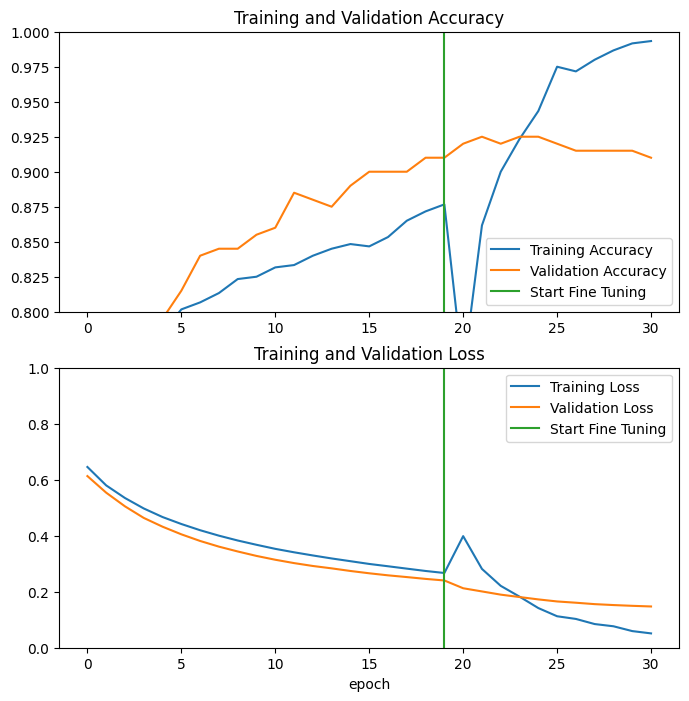

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 [==============================] - 0s 26ms/step


array([[-4.3025537]], dtype=float32)

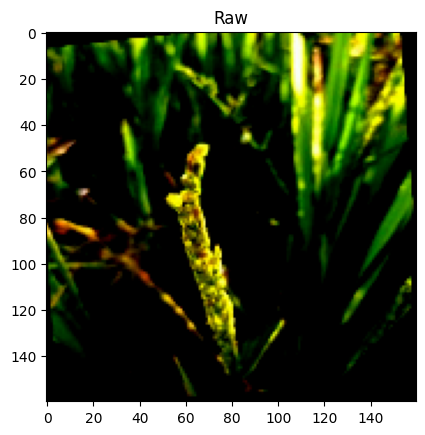

In [34]:
test_batches = test.batch(1)
for image, label in test_batches.take(1):
  pass
plt.imshow(np.squeeze(image))
plt.title("Ripe" if model.predict(image) > 0 else "Raw")
model.predict(image)

In [35]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as keras_image
from ipywidgets import widgets
from IPython.display import display, clear_output
import io
from PIL import Image

# Load your model
# model = tf.keras.models.load_model('path_to_your_model') # Uncomment and set the path to your model

def preprocess_image(img):
    img = img.resize((224, 224))  # Adjust target_size to match your model's input size
    img_array = keras_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the image if your model expects normalized images
    return img_array

def predict_image(model, img_array):
    prediction = model.predict(img_array)
    return prediction

def on_upload_change(change):
    clear_output(wait=True)
    uploaded_file = change['new']
    if uploaded_file:
        for name, file_info in uploaded_file.items():
            content = file_info['content']
            img = Image.open(io.BytesIO(content))
            img_array = preprocess_image(img)
            prediction = predict_image(model, img_array)

            print(prediction)

            plt.imshow(np.squeeze(img_array))
            plt.title("Ripe" if prediction > 0 else "Raw")
            plt.show()

            print("Prediction:", "Ripe" if prediction > 0 else "Raw")

            print("Keterangan:")
            if(prediction > 0):
              print("1 bulan lagi padi siap dipanen!")
            else:
              print("Lebih dari 1 bulan lagi untuk padi siap panen!")

upload_button = widgets.FileUpload(accept='image/*', multiple=False)
upload_button.observe(on_upload_change, names='value')

display(upload_button)


FileUpload(value={}, accept='image/*', description='Upload')

In [36]:
model.save("rice_plant_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [37]:
export_dir = 'rice_plant_model'
tf.saved_model.save(model, export_dir)

In [38]:
#convert the model to tflite
converter = tf.lite.TFLiteConverter.from_saved_model('rice_plant_model')
tflite_model = converter.convert()

In [39]:
with open('/content/rice_plant_model/rice_plant_model.tflite', 'wb') as f:
  f.write(tflite_model)